<a href="https://colab.research.google.com/github/mgiorgi13/brain_tumor_classifier/blob/mattia/InceptionV3_pretrained_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

from keras.applications import VGG16
from keras.models import Sequential ,load_model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D


## Google Drive connection

In [2]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utilities

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import backend as K
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# Percorso della cartella "unified" che contiene le sottocartelle delle classi
base_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

models_path = "/content/drive/MyDrive/BrainTumorDataset/Models"
cnn_results_path = os.path.join(models_path, 'CNN')
vgg16_results_path = os.path.join(models_path, 'VGG16')
resnet50_results_path = os.path.join(models_path, 'ResNet50')
inceptionv3_results_path = os.path.join(models_path, 'InceptionV3')
# actual_results_path = vgg16_results_path

def set_seed ():
	''' 
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)     

# Definisci le dimensioni delle immagini
image_size = 224
batch_size = 32

# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
     

def show_training_and_validation_performance(history,path):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.savefig(path)

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, type, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param type: type of model, CNN, VGG16, ResNet50, InceptionV3
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = os.path.join(models_path, type + '/' + model_name + '.h5') 
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=True)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history,os.path.join(models_path, type + '/' + model_name + '_validation.png'))

def plot_roc_curve(y_true, y_pred, n_classes, class_labels, model_name, type):

    # Converti le etichette di classe in formato binario
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # Calcola i tassi di FPR e TPR per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']  # Colori per le diverse classi

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(models_path, type + '/' + model_name + '_ROC.png'))
    plt.show()

def evaluate_model (model, test_generator, model_name, type):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''
	labels_d= ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())
	
	print("Classification report: ")
	# create and show classification report
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# save classification report
	with open(os.path.join(models_path, type + '/' + model_name + '_classification_report.txt'), 'w') as f:
		f.write(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))

	# create and show confusion matrix	
	cm = confusion_matrix(y_true, y_pred)	
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
	disp.plot(xticks_rotation=45)
	
	# save confusion matrix
	plt.savefig(os.path.join(models_path, type, model_name + '_confusion_matrix.png'), bbox_inches='tight', pad_inches=0.1)
	plt.show()

	plot_roc_curve(y_true, y_score, 4, class_labels, model_name, type)

def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index 

def clear(model):
	del model
	K.clear_session() 

set_seed ()

Found 4520 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


## Load Inception V3

In [4]:
# Carica il modello InceptionV3 pre-addestrato, senza l'ultimo strato fully connected
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

# Feature extraction

## Experiment 1
InceptionV3 + dense layer 128 neuron

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 28,357,028
Trainable params: 6,554,244
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 3.0264 - accuracy: 0.5735
Epoch 1: val_loss improved from inf to 0.80631, saving model to /conten

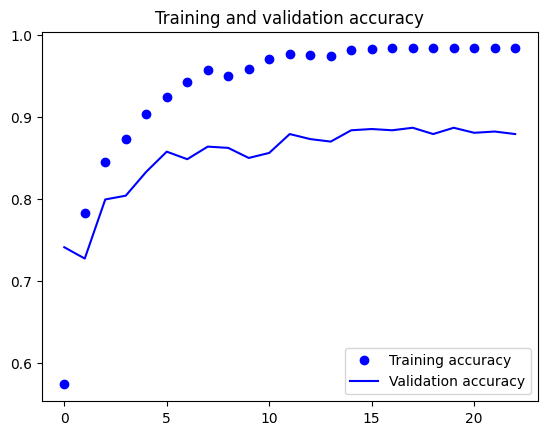

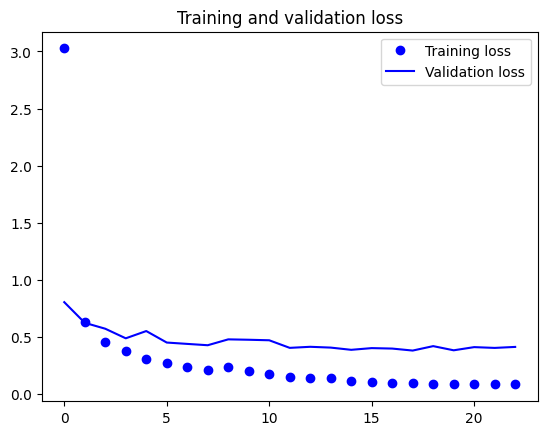

21/21 [==============================] - 125s 6s/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8474    0.8703    0.8587       185
meningioma_tumor     0.8187    0.7968    0.8076       187
        no_tumor     0.8942    0.9300    0.9118       100
 pituitary_tumor     0.9432    0.9222    0.9326       180

        accuracy                         0.8727       652
       macro avg     0.8759    0.8798    0.8777       652
    weighted avg     0.8728    0.8727    0.8726       652



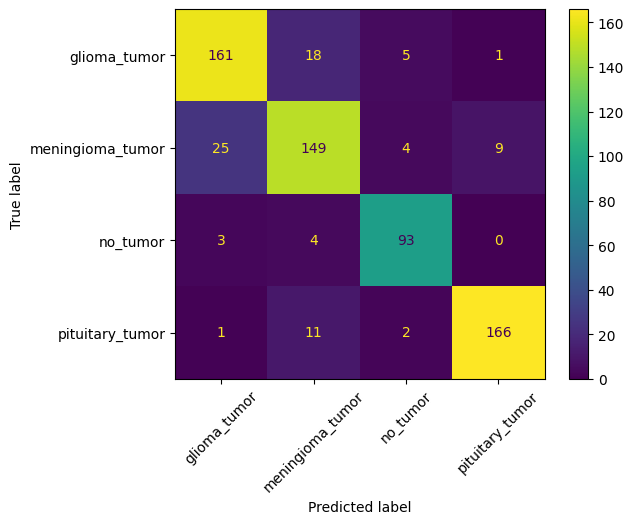

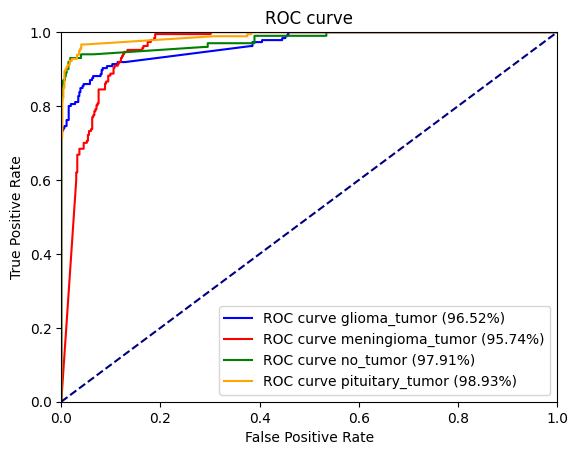

In [5]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'InceptionV3', "InceptionV3_128")

# Evaluate model
evaluate_model(model,test_generator, 'InceptionV3_128', "InceptionV3")

### suggerimento : 

Se la curva di validation dell'accuracy oscilla, alza e abbassa, potrebbe essere un segnale di overfitting. Questo perché il modello sta diventando troppo complesso e si sta adattando troppo bene ai dati di addestramento. Inoltre, l'oscillazione potrebbe essere dovuta alla presenza di troppa varianza nei dati di addestramento o ad una dimensione insufficiente del dataset di addestramento.

Un altro possibile motivo per cui la curva di validation dell'accuracy oscilla potrebbe essere la sensibilità del modello alla configurazione dei dati di addestramento e di validazione. Ad esempio, se la suddivisione dei dati di addestramento e di validazione non è stata effettuata in modo casuale, potrebbe esserci una certa correlazione tra i dati di addestramento e quelli di validazione che potrebbe influenzare la performance del modello.

In generale, se la curva di validation dell'accuracy oscilla, alza e abbassa, si consiglia di utilizzare tecniche di regolarizzazione come dropout o l1/l2 regularization per ridurre l'overfitting. Inoltre, potrebbe essere utile aumentare la dimensione del dataset di addestramento o utilizzare tecniche di data augmentation per aumentare la varietà dei dati di addestramento. Infine, è possibile considerare l'utilizzo di modelli più semplici o l'ottimizzazione dei parametri del modello per migliorare le performance.

## Experiment 2
InceptionV3 + 2 dense layer 128 neuron

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6553728   
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 28,373,540
Trainable params: 6,570,756
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
142/142 [=============

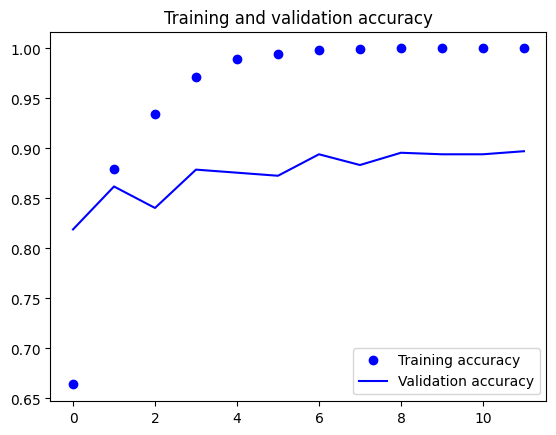

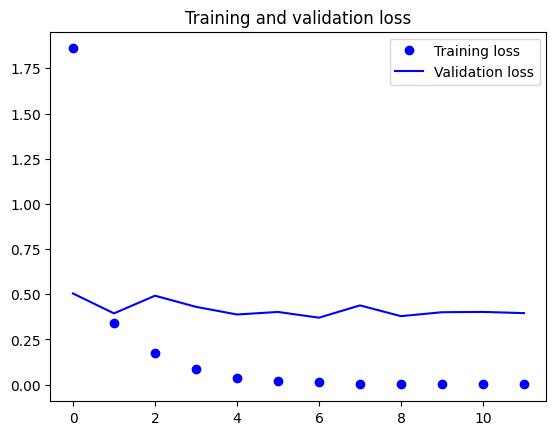

21/21 [==============================] - 6s 228ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8717    0.8811    0.8763       185
meningioma_tumor     0.8495    0.8449    0.8472       187
        no_tumor     0.9135    0.9500    0.9314       100
 pituitary_tumor     0.9371    0.9111    0.9239       180

        accuracy                         0.8896       652
       macro avg     0.8929    0.8968    0.8947       652
    weighted avg     0.8898    0.8896    0.8896       652



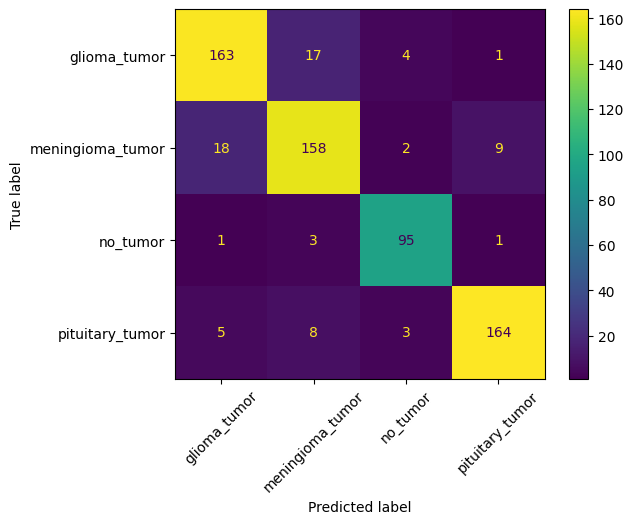

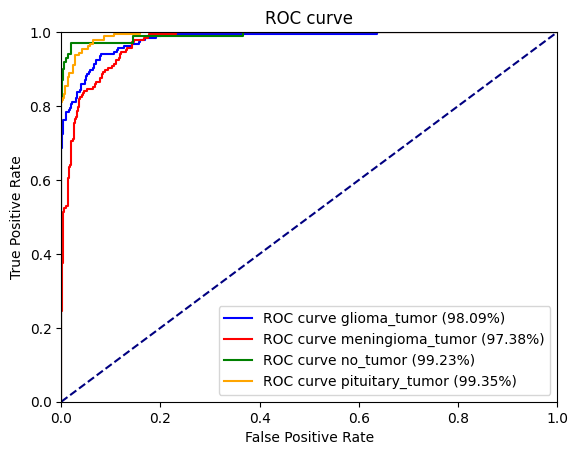

In [6]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'InceptionV3', "InceptionV3_128_128")

# Evaluate model
evaluate_model(model,test_generator, 'InceptionV3_128_128', "InceptionV3")

### suggerimento : 

Se la curva di validation dell'accuracy oscilla, alza e abbassa, potrebbe essere un segnale di overfitting. Questo perché il modello sta diventando troppo complesso e si sta adattando troppo bene ai dati di addestramento. Inoltre, l'oscillazione potrebbe essere dovuta alla presenza di troppa varianza nei dati di addestramento o ad una dimensione insufficiente del dataset di addestramento.

Un altro possibile motivo per cui la curva di validation dell'accuracy oscilla potrebbe essere la sensibilità del modello alla configurazione dei dati di addestramento e di validazione. Ad esempio, se la suddivisione dei dati di addestramento e di validazione non è stata effettuata in modo casuale, potrebbe esserci una certa correlazione tra i dati di addestramento e quelli di validazione che potrebbe influenzare la performance del modello.

In generale, se la curva di validation dell'accuracy oscilla, alza e abbassa, si consiglia di utilizzare tecniche di regolarizzazione come dropout o l1/l2 regularization per ridurre l'overfitting. Inoltre, potrebbe essere utile aumentare la dimensione del dataset di addestramento o utilizzare tecniche di data augmentation per aumentare la varietà dei dati di addestramento. Infine, è possibile considerare l'utilizzo di modelli più semplici o l'ottimizzazione dei parametri del modello per migliorare le performance.

## Experiment 3
InceptionV3 + 2 dense layer 128 neuron and dropout

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               6553728   
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 28,373,540
Trainable params: 6,570,756
N

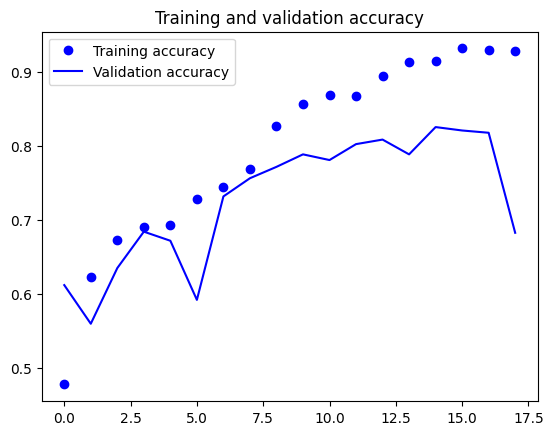

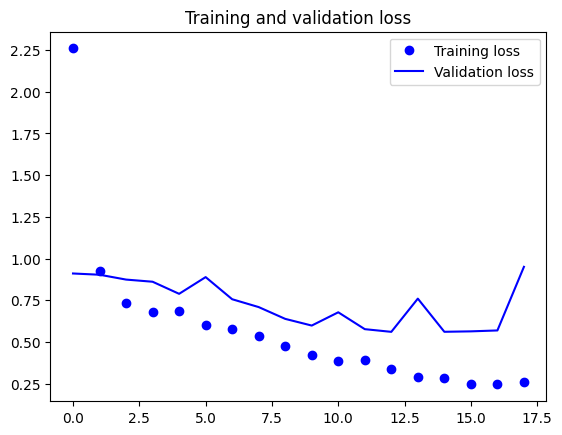

21/21 [==============================] - 5s 181ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9882    0.4541    0.6222       185
meningioma_tumor     0.5000    0.5561    0.5266       187
        no_tumor     0.8611    0.9300    0.8942       100
 pituitary_tumor     0.6693    0.9333    0.7796       180

        accuracy                         0.6887       652
       macro avg     0.7547    0.7184    0.7057       652
    weighted avg     0.7407    0.6887    0.6800       652



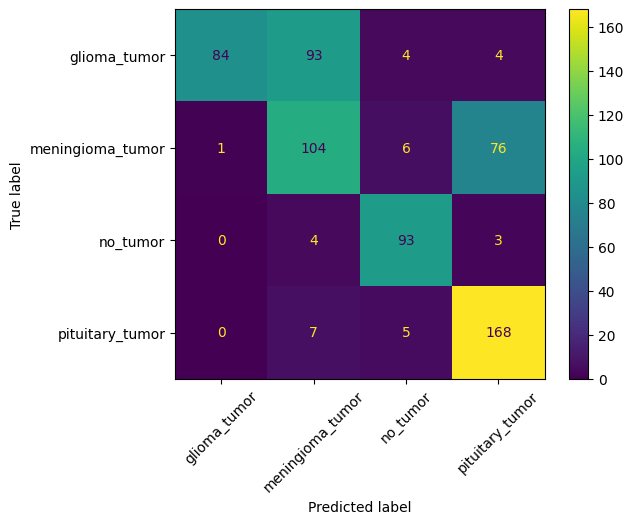

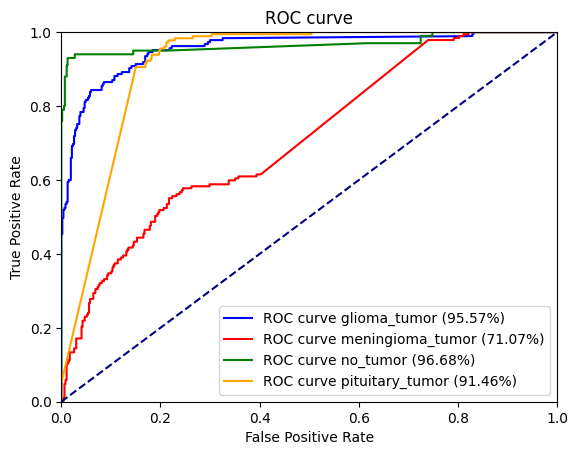

In [7]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'InceptionV3',"InceptionV3_128_128_drop")

# Evaluate model
evaluate_model(model,test_generator, "InceptionV3_128_128_drop", 'InceptionV3')

## Experiment 4
InceptionV3 + 2 dense layer with 128 and 128 neuron and dropout and glob avg pool

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 4)                 516       
                                                      

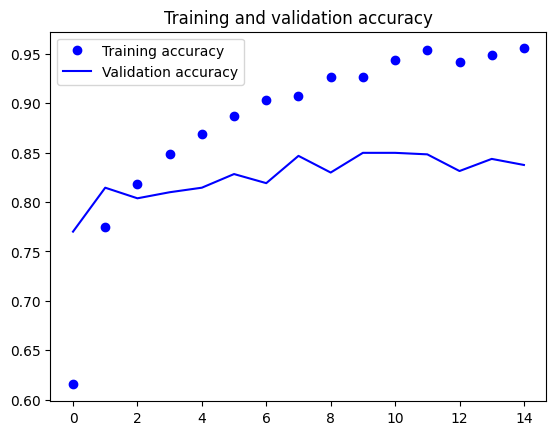

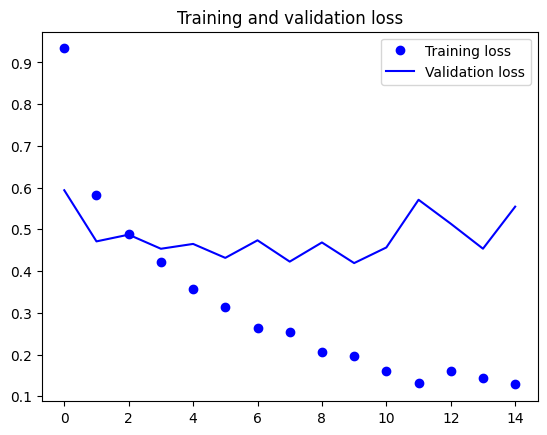

21/21 [==============================] - 6s 202ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8191    0.8324    0.8257       185
meningioma_tumor     0.8582    0.6471    0.7378       187
        no_tumor     0.8868    0.9400    0.9126       100
 pituitary_tumor     0.7926    0.9556    0.8665       180

        accuracy                         0.8298       652
       macro avg     0.8392    0.8438    0.8357       652
    weighted avg     0.8334    0.8298    0.8251       652



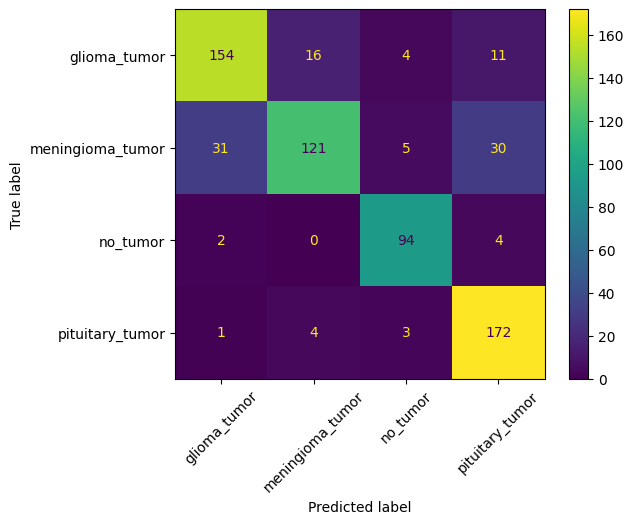

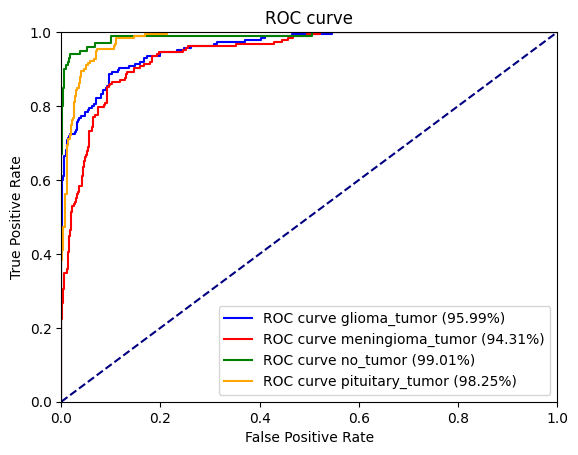

In [8]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'InceptionV3', "InceptionV3_128_128_drop_gap")

# Evaluate model
evaluate_model(model,test_generator, 'InceptionV3_128_128_drop_gap', "InceptionV3")

# Fine Tuning

## Experiments on the previous best attempts unlocking last inception block.

## Experiment 1
Unlocked the last inception block of InceptionV3 with the first experiment.
InceptionV3 + dense layer 128 neuron.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               6553728   
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 28,373,540
Trainable params: 6,570,756
N

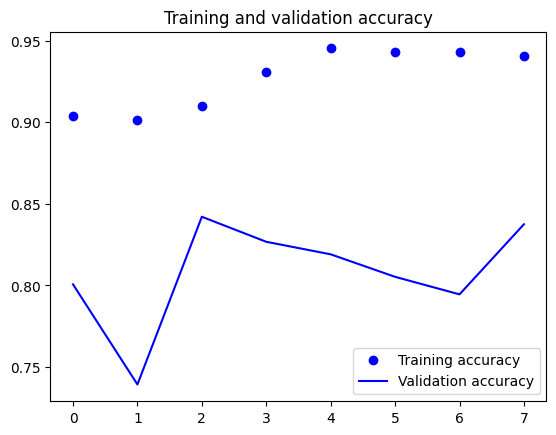

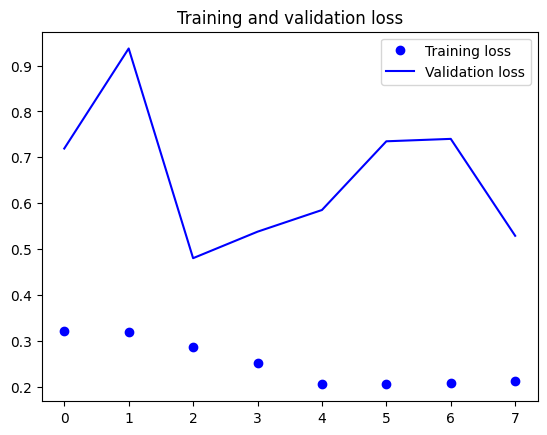

21/21 [==============================] - 6s 207ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8446    0.8811    0.8624       185
meningioma_tumor     0.7471    0.6791    0.7115       187
        no_tumor     0.9674    0.8900    0.9271       100
 pituitary_tumor     0.8223    0.9000    0.8594       180

        accuracy                         0.8298       652
       macro avg     0.8453    0.8376    0.8401       652
    weighted avg     0.8293    0.8298    0.8282       652



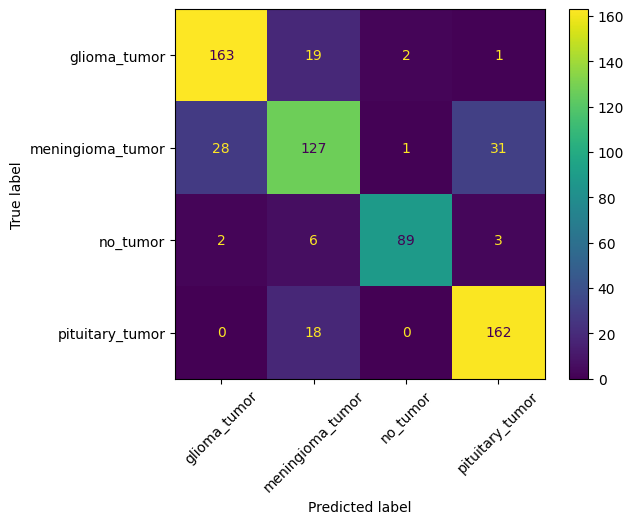

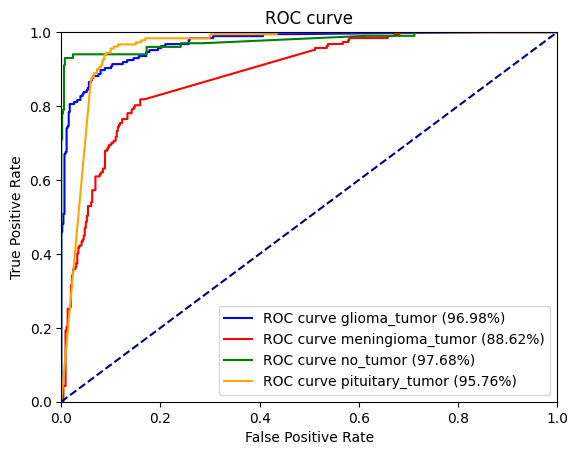

In [10]:
models_path = dataset_path + "/Models/InceptionV3/"
model_name = "InceptionV3_128_128_drop"

model = tf.keras.models.load_model(models_path  + model_name + ".h5")

set_trainable = False
for layer in model.get_layer('inception_v3').layers:
    if layer.name == 'mixed9 (Concatenate)':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model) # da rivedere

# Addestra il modello
run_model(model, 'InceptionV3', "InceptionV3_128_128_drop_fine_tuning")

evaluate_model(model, test_generator, "InceptionV3_128_128_drop_fine_tuning", "InceptionV3")

## Experiments on the previous best attempts unlocking last two inception block.

## Experiment 2

Unlocked the last two inception block of InceptionV3 with the first experiment. InceptionV3 + dense layer 128 neuron.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               6553728   
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 28,373,540
Trainable params: 6,570,756
N

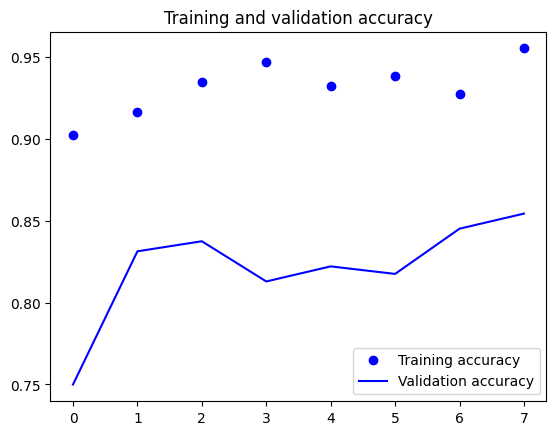

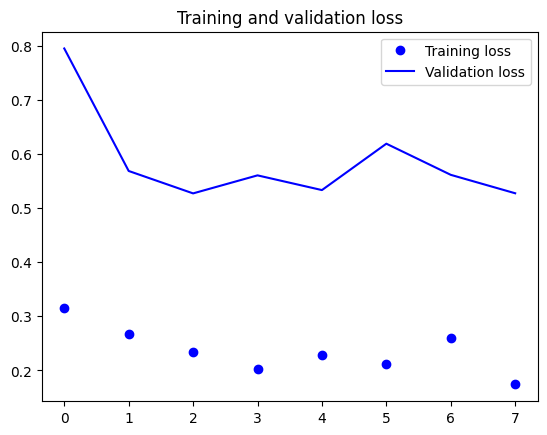

21/21 [==============================] - 6s 209ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8914    0.8432    0.8667       185
meningioma_tumor     0.7500    0.7380    0.7439       187
        no_tumor     0.8857    0.9300    0.9073       100
 pituitary_tumor     0.8404    0.8778    0.8587       180

        accuracy                         0.8359       652
       macro avg     0.8419    0.8472    0.8442       652
    weighted avg     0.8359    0.8359    0.8355       652



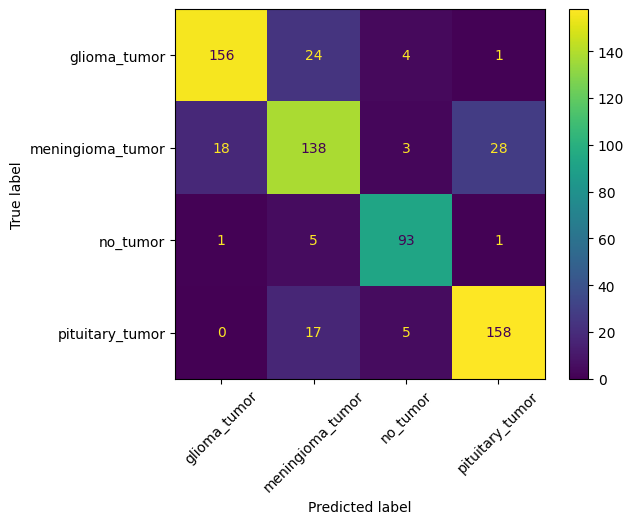

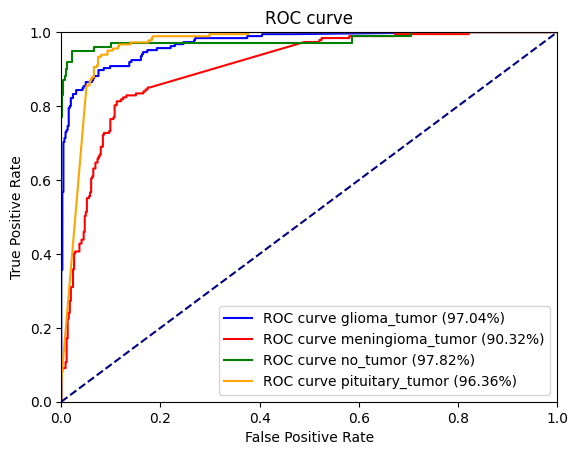

In [11]:
models_path = dataset_path + "/Models/InceptionV3/"
model_name = "InceptionV3_128_128_drop"

model = tf.keras.models.load_model(models_path  + model_name + ".h5")

set_trainable = False
for layer in model.get_layer('inception_v3').layers:
    if layer.name == 'mixed8 (Concatenate)':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model) # da rivedere

# Addestra il modello
run_model(model, 'InceptionV3', "InceptionV3_128_128_drop_fine_tuning_2")

evaluate_model(model, test_generator, "InceptionV3_128_128_drop_fine_tuning_2", "InceptionV3")